In [1]:

import pandas as pd
import numpy as np

# For splitting data, building model, and evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Adjust this path to point to your BM2425.xlsx in Drive
excel_file_path = '/Users/marclambertes/Python/Matches/Women/2024-2025/Leagues - Project/Pass/Belgium - Pass.xlsx'
df = pd.read_excel(excel_file_path)

df = df.sort_values('timeStamp').reset_index(drop=True)

df['next_1_typeId'] = df['typeId'].shift(-1)
df['next_2_typeId'] = df['typeId'].shift(-2)
df['next_3_typeId'] = df['typeId'].shift(-3)

##############################################
# STEP 4: DEFINE leads_to_shot
##############################################
df['leads_to_shot'] = 0  # default

valid_shot_ids = [13, 14, 15, 16]  # these typeIds lead to shot
df.loc[
    (df['Cross'] == 1) & (
        df['next_1_typeId'].isin(valid_shot_ids) |
        df['next_2_typeId'].isin(valid_shot_ids) |
        df['next_3_typeId'].isin(valid_shot_ids)
    ),
    'leads_to_shot'
] = 1

# (Optional) Preview the result
print("\n--- DataFrame After Adding leads_to_shot ---")
print(df.head(20))  # check the first 20 rows

##############################################
# STEP 5: FEATURE ENGINEERING
##############################################
# Example: Combine timeMin & timeSec -> totalTime
df['totalTime'] = df['timeMin'] * 60 + df['timeSec']

# Let's define our target
y = df['leads_to_shot']

# Example feature columns: adjust to what you actually have/need
# If some columns don't exist, remove or replace them
feature_cols = [
    'periodId',
    'totalTime',
    'x', 'y',
    'endX', 'endY',
    'outcome',    # If this is 1=success, 0=fail or a similar numeric
    'Corner',
    'Cutback',
    'LongBall'
]

# Make sure all columns exist before proceeding
for col in feature_cols:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in df. Removing from feature_cols.")
        feature_cols.remove(col)

# Build your feature matrix X
X = df[feature_cols].copy()

# Ensure columns that are booleans or 0/1 are actually numeric
# For example:
bool_cols = ['Corner','Cutback','LongBall']
for c in bool_cols:
    if c in X.columns:
        X[c] = X[c].astype(int)  # Convert to 0/1 if not already

# If 'outcome' is text like "Successful"/"Unsuccessful", you need to map it:
# outcome_mapping = {"Successful": 1, "Unsuccessful": 0}
# X['outcome'] = X['outcome'].map(outcome_mapping)

# (Optional) Check for missing values or strange data
# print(X.isna().sum())

##############################################
# STEP 6: SPLIT INTO TRAIN & TEST
##############################################
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,     # reproducibility
    stratify=y           # preserve class distribution if possible
)

print("\n--- Data Splits ---")
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

##############################################
# STEP 7: TRAIN MODELS
##############################################

# (A) Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# (B) Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

##############################################
# STEP 8: EVALUATE
##############################################
# Logistic Regression
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob_lr), 3))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

print("\n=== Random Forest Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob_rf), 3))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


--- DataFrame After Adding leads_to_shot ---
            id  eventId  typeId  periodId  timeMin  timeSec  \
0   2703420733        1      34        16        0        0   
1   2703422263        1      34        16        0        0   
2   2703438669        2      32         1        0        0   
3   2703438677        2      32         1        0        0   
4   2703438711        3       1         1        0        0   
5   2703438715        4       1         1        0        2   
6   2703438735        3      61         1        0        3   
7   2703438739        5       1         1        0        5   
8   2703438757        4       5         1        0        9   
9   2703438763        6       5         1        0        9   
10  2703438853        5       1         1        0       19   
11  2703438869        7       1         1        0       21   
12  2703438877        8       1         1        0       21   
13  2703438883        9      49         1        0       25   
14  27034

/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression Results ===
Accuracy: 0.996
ROC AUC: 0.984
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     58618
           1       0.63      0.07      0.12       249

    accuracy                           1.00     58867
   macro avg       0.81      0.53      0.56     58867
weighted avg       0.99      1.00      0.99     58867


=== Random Forest Results ===
Accuracy: 0.997
ROC AUC: 0.989
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     58618
           1       0.69      0.45      0.55       249

    accuracy                           1.00     58867
   macro avg       0.84      0.73      0.77     58867
weighted avg       1.00      1.00      1.00     58867



In [4]:
import pandas as pd

# Assuming you have already loaded the dataframe `df` and trained model `rf_model`

# (A) Filter only cross events
crosses_df = df[df['Cross'] == 1].copy()

# (B) Build the same feature matrix (X_crosses) with the same feature_cols
X_crosses = crosses_df[feature_cols].copy()

# Ensure conversions match training
for bcol in bool_cols:
    if bcol in X_crosses.columns:
        X_crosses[bcol] = X_crosses[bcol].astype(int)

# (C) Predict probabilities with, say, the Random Forest
cross_shot_probs = rf_model.predict_proba(X_crosses)[:, 1]

# (D) Attach these probabilities back to crosses_df
crosses_df['shot_probability'] = cross_shot_probs

# (E) If you want to merge these back to the original df:
df['shot_probability'] = np.nan
df.loc[crosses_df.index, 'shot_probability'] = crosses_df['shot_probability']
# Save to Excel
output_file = 'cross_shot_probabilities.xlsx'
crosses_df.to_excel(output_file, index=False)

print("\n--- Probability of Leading to a Shot for Crosses ---")
print(crosses_df[['id', 'playerName', 'contestantId', 'Cross','typeId','shot_probability']].head(20))


print(f"Data saved to {output_file}")



--- Probability of Leading to a Shot for Crosses ---
             id    playerName               contestantId  Cross  typeId  \
74   2703440409       J. Seys  1oyb7oym5nwzny8vxf03szd2h      1       1   
149  2703441903     C. Tzolis  1oyb7oym5nwzny8vxf03szd2h      1       1   
297  2703445401    P. Pflücke  b7jmo07lqav0wfe2mtlzyspak      1       1   
471  2703583519       A. Nusa  1oyb7oym5nwzny8vxf03szd2h      1       1   
492  2703449255     K. Mrabti  b7jmo07lqav0wfe2mtlzyspak      1       1   
502  2703449797       J. Seys  1oyb7oym5nwzny8vxf03szd2h      1       1   
566  2703451029       A. Nusa  1oyb7oym5nwzny8vxf03szd2h      1       1   
584  2703451379     D. Foulon  b7jmo07lqav0wfe2mtlzyspak      1       1   
658  2703453093     C. Tzolis  1oyb7oym5nwzny8vxf03szd2h      1       1   
697  2703453915       J. Seys  1oyb7oym5nwzny8vxf03szd2h      1       1   
737  2703454819       J. Seys  1oyb7oym5nwzny8vxf03szd2h      1       1   
755  2703454971       A. Nusa  1oyb7oym5nwzny8

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Load the data from the Excel file
file_path = 'cross_shot_probabilities.xlsx'  # Update with your file path
df = pd.read_excel(file_path)

# Count the total number of "Cross" per player (where Cross == 1)
cross_totals = df[df['Cross'] == 1].groupby('playerName').size().reset_index(name='Total_Crosses')

# Sum the shot probability for each player
shot_prob_totals = df.groupby('playerName')['shot_probability'].sum().reset_index(name='Total_Shot_Probability')

# Merge the two totals dataframes
merged_df = pd.merge(cross_totals, shot_prob_totals, on='playerName')

# Set the style to FiveThirtyEight
plt.style.use('fivethirtyeight')

# Create a larger plot
plt.figure(figsize=(12, 8))

# Create the scatter plot
plt.scatter(merged_df['Total_Crosses'], merged_df['Total_Shot_Probability'])

# Label each point with the player name
for i in range(len(merged_df)):
    plt.text(merged_df['Total_Crosses'].iloc[i], 
             merged_df['Total_Shot_Probability'].iloc[i], 
             merged_df['playerName'].iloc[i], 
             fontsize=8, 
             alpha=0.7, 
             color='black')

# Title and labels
plt.title('Scatter Plot of Total Crosses vs Total Shot Probability', fontsize=14)
plt.xlabel('Total Crosses', fontsize=12)
plt.ylabel('Total Shot Probability', fontsize=12)

# Optional: Add a logo to the plot
# Replace with your own image file path
logo_path = 'Outswinger FC (3).png'  # Update with your logo file path

# Open and resize the image (e.g., to 100x100 pixels)
img = Image.open(logo_path)
img = img.resize((100, 100))  # Resize logo to fit the plot

# Save the resized image to a temporary file
img.save('resized_logo.png')

# Load and display the resized logo image
img = mpimg.imread('resized_logo.png')
plt.imshow(img, aspect='auto', extent=[150, 200, 0, 0.1], alpha=0.3)  # Adjust position of logo

# Show the plot
plt.show()


ValueError: Image size of 4193x270615 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x800 with 1 Axes>

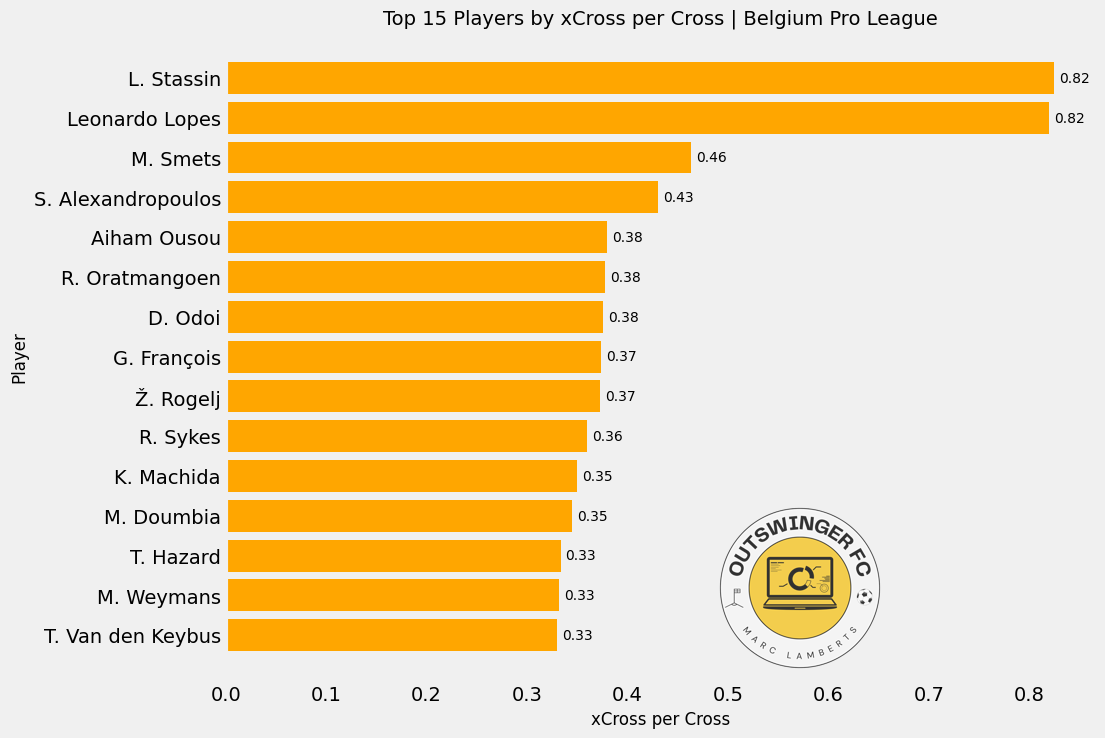

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Load the uploaded Excel file
file_path = "cross_shot_probabilities.xlsx"
df = pd.read_excel(file_path)

# Count the total number of crosses per player (where Cross == 1) and compute xCross per cross
cross_totals = df[df['Cross'] == 1].groupby('playerName').size().reset_index(name='Total_Crosses')
shot_prob_totals = df[df['Cross'] == 1].groupby('playerName')['shot_probability'].sum().reset_index(name='Total_Shot_Probability')

# Merge the data to calculate xCross per cross
cross_totals = pd.merge(cross_totals, shot_prob_totals, on='playerName')
cross_totals['xCross_per_Cross'] = cross_totals['Total_Shot_Probability'] / cross_totals['Total_Crosses']

# Sort by xCross per cross and select top 15 players
top_15_crosses = cross_totals.sort_values(by='xCross_per_Cross', ascending=False).head(15)

# Set style to fivethirtyeight
plt.style.use('fivethirtyeight')

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_15_crosses['playerName'], top_15_crosses['xCross_per_Cross'], color='#ffa600')

# Customize the chart
ax.set_xlabel('xCross per Cross', fontsize=12)
ax.set_ylabel('Player', fontsize=12)
ax.set_title('Top 15 Players by xCross per Cross | Belgium Pro League', fontsize=14)
ax.invert_yaxis()  # Invert y-axis so the top player is at the top
ax.grid(False)  # Remove grid

# Show value next to each bar
for index, value in enumerate(top_15_crosses['xCross_per_Cross']):
    ax.text(value + 0.005, index, f"{value:.2f}", fontsize=10, verticalalignment='center')

# Load and add logo (adjust the path accordingly)
logo_path = "Outswinger FC (3).png"  # Update this with your logo file path
try:
    img = Image.open(logo_path)
    img = img.resize((100, 100))  # Resize logo to fit plot
    img = mpimg.imread(logo_path)
    ax.figure.figimage(img, xo=700, yo=50, alpha=0.8)  # Adjust position of logo
except FileNotFoundError:
    print("Logo file not found. Skipping logo placement.")

# Save the plot as a PNG file
plt.savefig("top_15_xCross_per_Cross.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


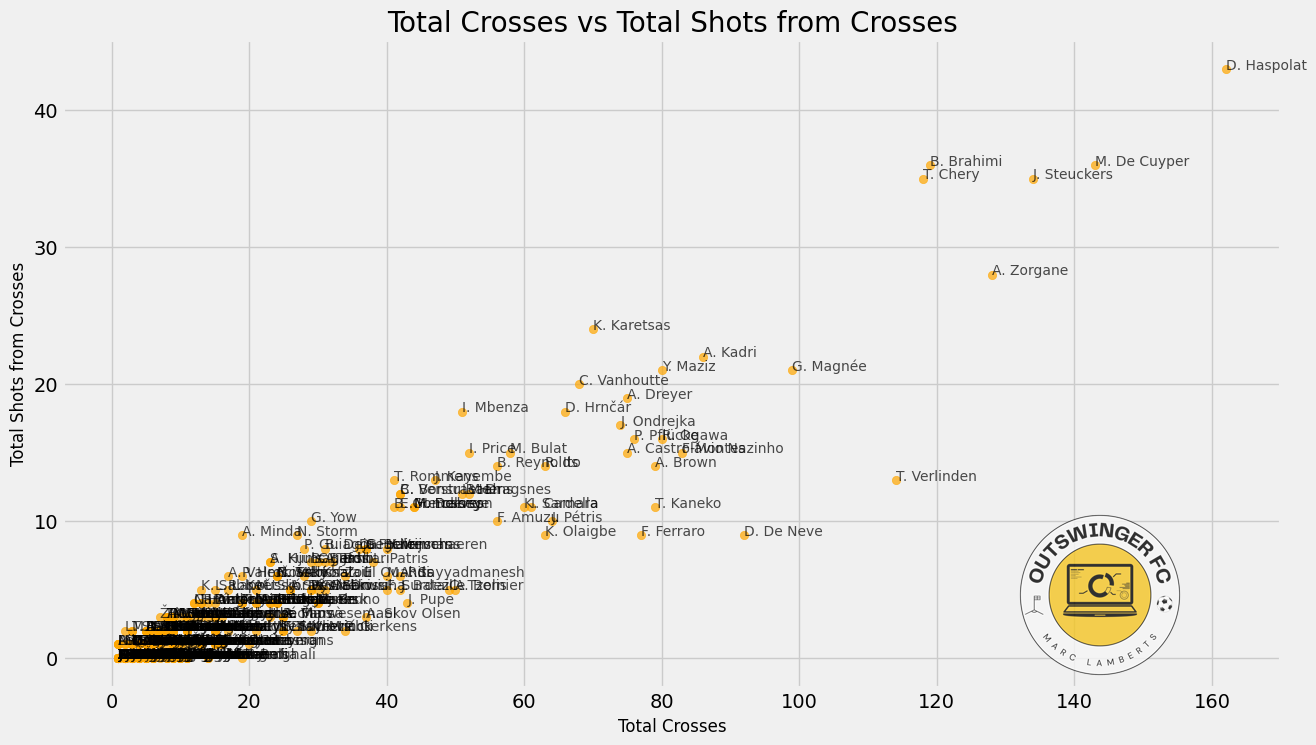

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# Load the uploaded Excel file
file_path = "cross_shot_probabilities.xlsx"
df = pd.read_excel(file_path)

# Count the total number of crosses per player (where Cross == 1) and compute xCross per cross
cross_totals = df[df['Cross'] == 1].groupby('playerName').size().reset_index(name='Total_Crosses')
shot_prob_totals = df[df['Cross'] == 1].groupby('playerName')['leads_to_shot'].sum().reset_index(name='Total_Shots')

# Merge the data to calculate xCross per cross
cross_totals = pd.merge(cross_totals, shot_prob_totals, on='playerName')
cross_totals['Shot_Percentage'] = cross_totals['Total_Shots'] / cross_totals['Total_Crosses']

# Set style to fivethirtyeight
plt.style.use('fivethirtyeight')

# Create scatter plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(cross_totals['Total_Crosses'], cross_totals['Total_Shots'], color='#ffa600', alpha=0.7)

# Annotate player names
for i, row in cross_totals.iterrows():
    ax.text(row['Total_Crosses'], row['Total_Shots'], row['playerName'], fontsize=10, alpha=0.7)

# Customize the chart
ax.set_xlabel('Total Crosses', fontsize=12)
ax.set_ylabel('Total Shots from Crosses', fontsize=12)
ax.set_title('Total Crosses vs Total Shots from Crosses', fontsize=20)
ax.grid(True)

# Load and add logo (adjust the path accordingly)
logo_path = "Outswinger FC (3).png"  # Update this with your logo file path
try:
    img = Image.open(logo_path)
    img = img.resize((100, 100))  # Resize logo to fit plot
    img = mpimg.imread(logo_path)
    ax.figure.figimage(img, xo=1000, yo=50, alpha=0.8)  # Adjust position of logo
except FileNotFoundError:
    print("Logo file not found. Skipping logo placement.")

# Save the plot as a PNG file
plt.savefig("scatterplot_crosses_vs_shots.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


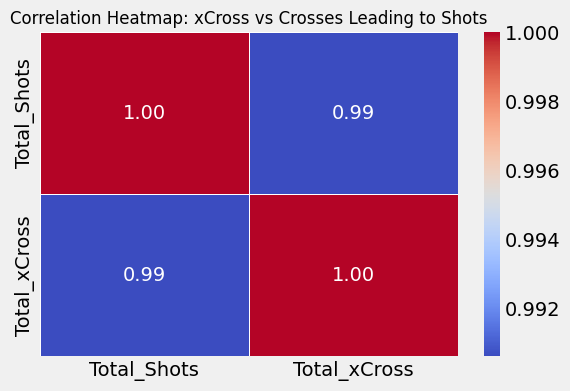

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the uploaded Excel file
file_path = "cross_shot_probabilities.xlsx"
df = pd.read_excel(file_path)

# Count the total number of crosses per player (where Cross == 1) and compute xCross per cross
cross_totals = df[df['Cross'] == 1].groupby('playerName').size().reset_index(name='Total_Crosses')
shot_totals = df[df['Cross'] == 1].groupby('playerName')['leads_to_shot'].sum().reset_index(name='Total_Shots')
xCross_totals = df[df['Cross'] == 1].groupby('playerName')['shot_probability'].sum().reset_index(name='Total_xCross')

# Merge datasets
correlation_data = cross_totals.merge(shot_totals, on='playerName').merge(xCross_totals, on='playerName')

# Calculate correlation
correlation = correlation_data[['Total_Shots', 'Total_xCross']].corr()

# Set plot style
plt.style.use('fivethirtyeight')

# Create heatmap for correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Customize the chart
plt.title("Correlation Heatmap: xCross vs Crosses Leading to Shots", fontsize=12)

# Show the plot
plt.show()


# IMPROVEMENTS


In [ ]:
import pandas as pd
import numpy as np

# For splitting data, building model, and evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Load dataset
excel_file_path = '/Users/marclambertes/Python/Matches/Women/2024-2025/Leagues - Project/Pass/Belgium - Pass.xlsx'
df = pd.read_excel(excel_file_path)

# Sort values by timeStamp
df = df.sort_values('timeStamp').reset_index(drop=True)

# Add next event type columns
df['next_1_typeId'] = df['typeId'].shift(-1)
df['next_2_typeId'] = df['typeId'].shift(-2)
df['next_3_typeId'] = df['typeId'].shift(-3)

# Add previous event type columns
df['prev_1_typeId'] = df['typeId'].shift(1)
df['prev_2_typeId'] = df['typeId'].shift(2)

# Define leads_to_shot
df['leads_to_shot'] = 0
valid_shot_ids = [13, 14, 15, 16]
df.loc[
    (df['Cross'] == 1) & (
        df['next_1_typeId'].isin(valid_shot_ids) |
        df['next_2_typeId'].isin(valid_shot_ids) |
        df['next_3_typeId'].isin(valid_shot_ids)
    ),
    'leads_to_shot'
] = 1

# Feature Engineering: Calculate distance to goal (assuming goal at x=100, y=50)
df['distance_to_goal'] = np.sqrt((100 - df['endX'])**2 + (50 - df['endY'])**2)

# Feature Engineering: Calculate angle of cross
df['angle_of_cross'] = np.arctan2((df['endY'] - df['y']), (df['endX'] - df['x']))

# Feature Engineering: Combine timeMin & timeSec -> totalTime
df['totalTime'] = df['timeMin'] * 60 + df['timeSec']

# Target variable
y = df['leads_to_shot']

# Feature columns
feature_cols = [
    'periodId', 'totalTime', 'x', 'y', 'endX', 'endY', 'outcome', 'Corner', 'Cutback', 'LongBall',
    'distance_to_goal', 'angle_of_cross', 'prev_1_typeId', 'prev_2_typeId'
]

# Ensure all columns exist
for col in feature_cols:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in df. Removing from feature_cols.")
        feature_cols.remove(col)

X = df[feature_cols].copy()

# Convert boolean features to integers
bool_cols = ['Corner', 'Cutback', 'LongBall']
for c in bool_cols:
    if c in X.columns:
        X[c] = X[c].astype(int)

# Handle missing values
X.fillna(X.median(), inplace=True)

# Remove outliers (IQR Method)
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] > (Q1 - 1.5 * IQR)) & (df[col] < (Q3 + 1.5 * IQR))]

for col in ['x', 'y', 'endX', 'endY', 'totalTime', 'distance_to_goal']:
    X = remove_outliers(X, col)

# One-hot encoding categorical variables
X = pd.get_dummies(X, columns=['outcome', 'periodId'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate model
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\n=== Random Forest Results ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob_rf), 3))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
